# [LANL competition](https://www.kaggle.com/c/LANL-Earthquake-Prediction)
- [introduction](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77525)
- [Benchmark analysis](https://www.kaggle.com/inversion/basic-feature-benchmark/notebook)
- [good EDA and discussion + comments](https://www.kaggle.com/allunia/shaking-earth/comments)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
os.path.abspath('.')

'/home/ben/github/LANL/notebooks'

In [3]:
version='v4'

In [4]:
root = 'D:\\LANL\\all' # windows
root = '/media/ben/data/kaggle/LANL/' # linux
os.listdir(root)

['all.zip',
 'sample_submission.csv',
 'test',
 'test.zip',
 'train.csv',
 'v1_submission.csv',
 'v1_train.hdf',
 'v2_submission.csv',
 'v2_train.hdf',
 'v3.1_submission.csv',
 'v3_submission.csv',
 'v4.1_submission.csv']

# Load Training Data

In [5]:
# # load 9GB csv
# train = pd.read_csv(os.path.join(root,'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

### Failure sequences
There are 16 failures in the data set, but the time-to-fail only ever reaches very small decimals.<br>
The last rows do *NOT* end in a failure. 

- when loading the data..
- Lets, use the time difference to identify where the T2F jumps back up and mark these as failures.

In [6]:
try:
    train = pd.read_hdf(os.path.join(root,'v2_train.hdf'.format(version)),'mydata')
    print('File Loaded')
except:
    print('File not found, running chunk load')
    # load in as chunks
    chunksize = 10 ** 6
    chunks = list()
    sequenceNumber = 0 # first failure sequence
    
    for chunk in tqdm(pd.read_csv(os.path.join(root,'train.csv'),
                             dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64},
                             chunksize=chunksize)):

        chunk['seq'] = chunk['time_to_failure'].diff() # get time difference between each step
        chunk['seq'] = (chunk['seq']>0).astype(float).copy() # float binary column where time_difference between steps is positive (i.e. reset after failure)
        chunk['seq'].values[0] = sequenceNumber # set first as sequenceNumber
        chunk['seq'] = chunk['seq'].cumsum().copy() # sum up sequence values
        chunks.append(chunk) # append results to list
        sequenceNumber = chunk['seq'].values[-1] # get latest sequnce number
        
    # concat chunks & save
    train = pd.concat(chunks)
    print('Out:{}'.format(len(train)))
    train.to_hdf(os.path.join(root,'{}_train.hdf'.format(version)),'mydata',mode='w')

File Loaded


In [7]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15
train.head()

,acoustic_data,time_to_failure,seq
0,12,1.4690999832,0.0
1,6,1.4690999821,0.0
2,8,1.4690999810,0.0
3,5,1.4690999799,0.0
4,8,1.4690999788,0.0


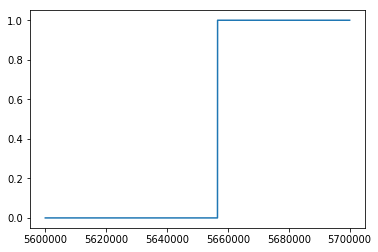

In [8]:
# lets check our sequnces worked on a known failure point
train['seq'][5600000:5700000].astype(float).plot();

In [9]:
sequences = np.arange(0,17,1)
sequenceDict = dict()
for seq in sequences:
    sequenceDict[seq] = train.loc[train['seq']==seq].reset_index(drop=True)
    print('Seq:{}, {}'.format(seq, len(sequenceDict[seq])), end='\r\n')

Seq:0, 5656574
Seq:1, 44429304
Seq:2, 54591478
Seq:3, 34095097
Seq:4, 48869367
Seq:5, 31010810
Seq:6, 27176955
Seq:7, 62009332
Seq:8, 30437370
Seq:9, 37101561
Seq:10, 43991032
Seq:11, 42442743
Seq:12, 33988602
Seq:13, 32976890
Seq:14, 56791029
Seq:15, 36417529
Seq:16, 7159807


# Training Data Prep

1. There are 150,000 rows in each test segment. 
2. The training data is reduced from 6 millions rows to summary features every 150,000 rows. (~5000 summary rows).
3. Lets use our sequenceFailure data to avoid summarising over failure points e.g. (5,4,3,2,1,0,5,4,3,2,1) 

## Feature Engineering

In [10]:
test = sequenceDict[0]
test1 = test[-150000:]
x = test1['acoustic_data']

In [11]:
def getSequenceSegments(sequenceDF,rows):
    segments = int(np.floor(sequenceDF.shape[0] / rows))
    return segments

In [12]:
getSequenceSegments(test,150000)

37

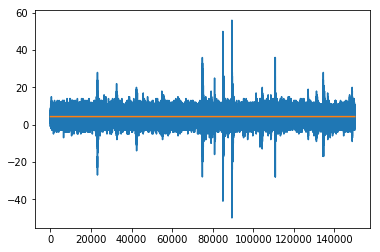

In [13]:
plt.plot(x.values)
plt.plot([x.mean()]*len(x))
#plt.plot(((x-x.mean())/x.std()).values)

In [14]:
def getFeatures(sequenceDF,seqID,getY=bool):
    acoustics = sequenceDF['acoustic_data'].copy()
    x = acoustics.values
    
    X_train = pd.DataFrame({'segID':seqID,
                            'ave':x.mean(),
                            'std':x.std(),
                            'max':x.max().astype(float),
                            'min':x.min().astype(float),
                            'total':abs(x).sum().astype(float), # total abs acoustic
                            'cumul':abs(x).cumsum().sum().astype(float),
                            'PoT05':len(x[(x >= x.mean()+0.5*x.std()) | (x <= x.mean()-0.5*x.std())])/len(x), # peaks over/under threshold (1*std)
                            'PoT1':len(x[(x >= x.mean()+1*x.std()) | (x <= x.mean()-1*x.std())])/len(x), # peaks over/under threshold (1*std))
                            'PoT2':len(x[(x >= x.mean()+2*x.std()) | (x <= x.mean()-2*x.std())])/len(x), # peaks over/under threshold (1*std)
                            'RDN1':float(len(x[abs(x)/abs(x).mean()>1])), # rainy day normal
                            'RDN4':float(len(x[abs(x)/abs(x).mean()>4])), # rainy day normal
                            'RDN8':float(len(x[abs(x)/abs(x).mean()>8])), # rainy day normal
                            'meanDiff':acoustics.diff().mean(), # change per step [max, median]
                            'stdDiff':acoustics.diff().std(), #  change per step [max, median]
                            'maxDiff':acoustics.diff().max(), #  change per step [max, median]
                            'Q001Diff':np.quantile(x,0.001), # Quantile
                            'Q01Diff':np.quantile(x,0.01), # Quantile
                            'Q05Diff':np.quantile(x,0.05), # Quantile
                            'Q10Diff':np.quantile(x,0.10), # Quantile
                            'Q999Diff':np.quantile(x,0.999), # Quantile
                            'Q99Diff':np.quantile(x,0.99), # Quantile
                            'Q95Diff':np.quantile(x,0.95), # Quantile
                            'Q90Diff':np.quantile(x,0.90), # Quantile
                            'Qrng10-90':np.subtract(*np.percentile(x, [90, 10])) # Quartile Range from 0.05 to 0.95% (range of values)
                           },index=[0])
    
    # IF so that we can re-use this later and not pass any y's
    if getY == True:
        y = sequenceDF['time_to_failure'].values[-1]
        y_train = pd.DataFrame({'segID':seqID,
                                'time_to_failure':y},index=[0])
        return X_train, y_train
    else:
        return X_train

In [15]:
getFeatures(test,99,getY=False)

,segID,ave,std,max,min,total,cumul,PoT05,PoT1,PoT2,...,maxDiff,Q001Diff,Q01Diff,Q05Diff,Q10Diff,Q999Diff,Q99Diff,Q95Diff,Q90Diff,Qrng10-90
0,99,4.560983026121465,23.427838329705629,3252.0,-4621.0,35185198.0,97168998187958.0,0.041876054304248,0.014699887246238,0.004396477443767,...,882.0,-69.0,-14.0,-3.0,0.0,79.0,24.0,12.0,10.0,10.0


In [16]:
# for r in [10,5000,20000,]:
#     x.rolling(window=r,min_periods=r).mean().plot()
    
# plt.plot(x.index, [x.mean()]*len(x))
# plt.plot(x.index, [x.mean()+x.std()]*len(x))
# plt.plot(x.index, [x.mean()-x.std()]*len(x))

In [17]:
# Create a training file with simple derived features
Xs = list()
ys = list()
rows = 150000
segID = 0

for seq in sequences:
    print(seq, end=',')
    sequenceDF = sequenceDict[seq].copy() # take copy of entire failure sequence
    nSegments = getSequenceSegments(sequenceDF,rows) # get number of 150,000 row segments per sequence
    
    for segment in range(nSegments):
        segDF = sequenceDF.iloc[segment*rows:segment*rows+rows].copy()
        xDF,yDF = getFeatures(segDF,segID,getY=True)
        segID+=1
        Xs.append(xDF)
        ys.append(yDF)
    
#     # manually add the last 150,000 to capture failure
#     segDF = sequenceDF[-rows:].copy()
#     xDF,yDF = getFeatures(segDF,segID)
#     segID+=1
#     X.append(xDF)
#     y.append(yDF)
    

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,

In [18]:
X_train = pd.concat(Xs,sort=False).reset_index(drop=True)
y_train = pd.concat(ys,sort=False).reset_index(drop=True)

In [19]:
X_train.head()

,segID,ave,std,max,min,total,cumul,PoT05,PoT1,PoT2,...,maxDiff,Q001Diff,Q01Diff,Q05Diff,Q10Diff,Q999Diff,Q99Diff,Q95Diff,Q90Diff,Qrng10-90
0,0,4.884113333333334,5.101089126891323,104.0,-98.0,836485.0,65908881756.0,0.474920000000000,0.182500000000000,0.033346666666667,...,32.0,-30.0,-8.0,-2.0,0.0,40.00000000000000,18.0,11.0,10.0,10.0
1,1,4.725766666666667,6.588801819164257,181.0,-154.0,860125.0,66025576390.0,0.336520000000000,0.115280000000000,0.029100000000000,...,78.0,-47.0,-11.0,-2.0,0.0,59.00000000000000,21.0,12.0,10.0,10.0
2,2,4.906393333333333,6.967373808828945,140.0,-106.0,922897.0,66426535142.0,0.362873333333333,0.121560000000000,0.038506666666667,...,47.0,-47.0,-15.0,-3.0,0.0,59.00000000000000,26.0,13.0,10.0,10.0
3,3,4.902240000000000,6.922282112791032,197.0,-199.0,890094.0,67391753310.0,0.340106666666667,0.101206666666667,0.028800000000000,...,68.0,-50.0,-12.0,-2.0,0.0,60.00099999998929,22.0,12.0,10.0,10.0
4,4,4.908720000000000,7.301085852684289,145.0,-126.0,916588.0,67425069281.0,0.342166666666667,0.091966666666667,0.032313333333333,...,43.0,-56.0,-15.0,-2.0,0.0,65.00000000000000,26.0,12.0,10.0,10.0


# Add Data Clusters

 - ### Choosing N Cluster
 - [Silhouette Score](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
 - [Cluster Score](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
### [KNN](https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/)
 - [sklearn doc](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [clustered regression](https://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho)

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans
k_score = {}
for k in tqdm(np.arange(40,150,10)):
    KM = KMeans(n_clusters=k,
                init='k-means++',
                max_iter=300,
                n_init=25,
                n_jobs=-1)
    
    k_score[k] = KM.fit(X_train.iloc[:,1:]).score(X_train.iloc[:,1:])

100%|██████████| 11/11 [00:34<00:00,  3.75s/it]


In [21]:
# silhoutte scoring
from sklearn.metrics import silhouette_samples, silhouette_score
silhouetteScores = list()

for k in tqdm(range(80,145,5)):
    KM = KMeans(n_clusters=k,
                init='k-means++',
                max_iter=300,
                n_init=25,
                n_jobs=-1
               )
    KM.fit(X_train.iloc[:,1:])
    silhouetteScores.append(silhouette_score(X_train.iloc[:,1:], KM.labels_, sample_size=10000, random_state=99))

100%|██████████| 13/13 [00:44<00:00,  4.00s/it]


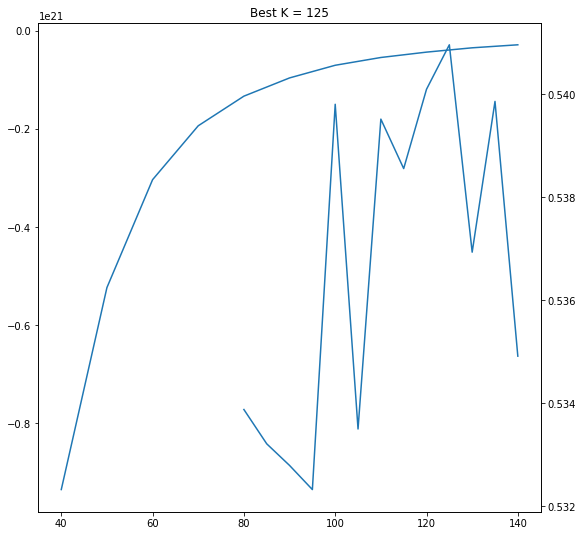

In [22]:
fig,axs = plt.subplots(1,1,figsize=(9,9))
ax2 = axs.twinx()

K = [x for x in range(80,145,5)][np.argmax(silhouetteScores)]

KM = KMeans(n_clusters=K,
            init='k-means++',
            max_iter=300,
            n_init=25,
            n_jobs=-1
           )
KM.fit(X_train.iloc[:,1:])

axs.set_title('Best K = {}'.format(K))

axs.plot(k_score.keys(),k_score.values());
ax2.plot(range(80,145,5),silhouetteScores);

In [25]:
# first set of clusters
X_train['Kmeans_{}'.format(K)] = KM.predict(X_train.iloc[:,1:]).astype(float)

In [27]:
X_train.iloc[:3,1:-1]

,ave,std,max,min,total,cumul,PoT05,PoT1,PoT2,RDN1,...,maxDiff,Q001Diff,Q01Diff,Q05Diff,Q10Diff,Q999Diff,Q99Diff,Q95Diff,Q90Diff,Qrng10-90
0,4.884113333333334,5.101089126891323,104.0,-98.0,836485.0,65908881756.0,0.474920000000000,0.18250,0.033346666666667,66626.0,...,32.0,-30.0,-8.0,-2.0,0.0,40.0,18.0,11.0,10.0,10.0
1,4.725766666666667,6.588801819164257,181.0,-154.0,860125.0,66025576390.0,0.336520000000000,0.11528,0.029100000000000,65204.0,...,78.0,-47.0,-11.0,-2.0,0.0,59.0,21.0,12.0,10.0,10.0
2,4.906393333333333,6.967373808828945,140.0,-106.0,922897.0,66426535142.0,0.362873333333333,0.12156,0.038506666666667,53637.0,...,47.0,-47.0,-15.0,-3.0,0.0,59.0,26.0,13.0,10.0,10.0


In [28]:
# manual add another 
K2 = 80
KM2 = KMeans(n_clusters=K2,
            init='k-means++',
            max_iter=300,
            n_init=25,
            n_jobs=-1
           )
KM2.fit(X_train.iloc[:,1:-1])
X_train['Kmeans_{}'.format(K2)] = KM2.predict(X_train.iloc[:,1:-1]).astype(float)

X_train.head()

,segID,ave,std,max,min,total,cumul,PoT05,PoT1,PoT2,...,Q01Diff,Q05Diff,Q10Diff,Q999Diff,Q99Diff,Q95Diff,Q90Diff,Qrng10-90,Kmeans_125,Kmeans_80
0,0,4.884113333333334,5.101089126891323,104.0,-98.0,836485.0,65908881756.0,0.474920000000000,0.182500000000000,0.033346666666667,...,-8.0,-2.0,0.0,40.00000000000000,18.0,11.0,10.0,10.0,114.0,50.0
1,1,4.725766666666667,6.588801819164257,181.0,-154.0,860125.0,66025576390.0,0.336520000000000,0.115280000000000,0.029100000000000,...,-11.0,-2.0,0.0,59.00000000000000,21.0,12.0,10.0,10.0,32.0,50.0
2,2,4.906393333333333,6.967373808828945,140.0,-106.0,922897.0,66426535142.0,0.362873333333333,0.121560000000000,0.038506666666667,...,-15.0,-3.0,0.0,59.00000000000000,26.0,13.0,10.0,10.0,96.0,16.0
3,3,4.902240000000000,6.922282112791032,197.0,-199.0,890094.0,67391753310.0,0.340106666666667,0.101206666666667,0.028800000000000,...,-12.0,-2.0,0.0,60.00099999998929,22.0,12.0,10.0,10.0,109.0,42.0
4,4,4.908720000000000,7.301085852684289,145.0,-126.0,916588.0,67425069281.0,0.342166666666667,0.091966666666667,0.032313333333333,...,-15.0,-2.0,0.0,65.00000000000000,26.0,12.0,10.0,10.0,109.0,42.0


# Feature Selection
- https://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/

### [Simple RFE](https://medium.com/@aneesha/recursive-feature-elimination-with-scikit-learn-3a2cbdf23fb7)
 - https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_digits.html#sphx-glr-auto-examples-feature-selection-plot-rfe-digits-py
 - https://www.kaggle.com/shrutigodbole15792/feature-selection
 - https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/

### [RFE Pipelines](https://stackoverflow.com/questions/32208546/combining-recursive-feature-elimination-and-grid-search-in-scikit-learn)
 - https://stackoverflow.com/questions/36683230/grid-search-with-recursive-feature-elimination-in-scikit-learn-pipeline-returns

In [29]:
from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LinearRegression

In [30]:
nFeatures = len(X_train.iloc[:,1:].columns)
print('N features = {}'.format(nFeatures))

N features = 26


In [31]:
# create the RFE model and select attributes
estimator = LinearRegression()

rfeResults = dict()

for x in tqdm([x for x in range(2,nFeatures+1,1)]):
    rfe = RFE(estimator, n_features_to_select=x, step=1)
    rfe = rfe.fit(X_train.iloc[:,1:], y_train.iloc[:,1].values.flatten())
    rfeResults[x] = rfe

100%|██████████| 25/25 [00:00<00:00, 33.02it/s]


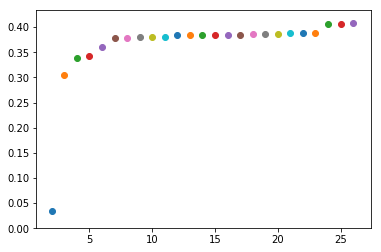

In [32]:
for k,v in rfeResults.items():
    # print summaries for the selection of attributes
    plt.scatter(k,v.score(X_train.iloc[:,1:], y_train.iloc[:,1].values.flatten()))
    #print(v.support_)
    #print(v.ranking_)

In [33]:
rfeResults[24].support_

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [34]:
X = X_train[X_train.iloc[:,1:].columns[rfeResults[24].support_]]
y = y_train.iloc[:,1].values.flatten()

# Train, Predict & Score
 - [notes on feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, make_scorer

In [36]:
MAEscorer = make_scorer(mean_absolute_error, greater_is_better=False)
models = list()

### [NuSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html#sklearn.svm.NuSVR)

In [37]:
from sklearn.svm import NuSVR
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',PCA()),
                 ('model', NuSVR())])

params = {'pca__n_components': [2,4,8,16],
          'model__kernel':['linear','rbf'],
          'model__nu': [0.5,0.75,0.9],
          'model__C': [1,2,2.5],
          'model__gamma': ['auto'],
          }

gs_NuSVR = GridSearchCV(estimator=pipe,
                        param_grid=params,
                        scoring=MAEscorer,
                        n_jobs=-1,
                        cv=3)

%time gs_NuSVR = gs_NuSVR.fit(X,y)
print('\n',gs_NuSVR.best_score_,'\n', gs_NuSVR.best_params_,)
models.append(gs_NuSVR)

CPU times: user 4.45 s, sys: 12.8 s, total: 17.3 s
Wall time: 25.5 s

 -2.183712726063604 
 {'model__C': 1, 'model__gamma': 'auto', 'model__kernel': 'rbf', 'model__nu': 0.75, 'pca__n_components': 16}


### [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [38]:
from xgboost import XGBRegressor
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',PCA()),
                 ('model', XGBRegressor())])

params = {'pca__n_components': [4,8,12,16],
          'model__max_depth':[3,4,5,10],
          'model__learning_rate': [0.001,0.01,0.1],
          'model__n_estimators': [25,30,35,50],}

gs_XGB = GridSearchCV(estimator=pipe,
                      param_grid=params,
                      scoring=MAEscorer,
                      n_jobs=-1,
                      cv=3)

%time gs_XGB = gs_XGB.fit(X,y)
print('\n',gs_XGB.best_score_,'\n', gs_XGB.best_params_,)
models.append(gs_XGB)

CPU times: user 4.43 s, sys: 353 ms, total: 4.78 s
Wall time: 8.51 s

 -2.212142714573979 
 {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 25, 'pca__n_components': 16}


### [Elasticnet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)

In [39]:
from sklearn.linear_model import ElasticNet
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca',PCA()),
                 ('model', ElasticNet())])

params = {'pca__n_components': [2,4,8,16],
          'model__alpha':[0.5,1.0],
          'model__l1_ratio': [0.75,1.0],
          'model__max_iter': [1000],}

gs_EN = GridSearchCV(estimator=pipe,
                      param_grid=params,
                      scoring=MAEscorer,
                      n_jobs=-1,
                      cv=3)

%time gs_EN = gs_EN.fit(X,y)
print('\n',gs_EN.best_score_,'\n', gs_EN.best_params_,)
models.append(gs_EN)

CPU times: user 246 ms, sys: 58.2 ms, total: 304 ms
Wall time: 299 ms

 -2.376895825658562 
 {'model__alpha': 0.5, 'model__l1_ratio': 0.75, 'model__max_iter': 1000, 'pca__n_components': 16}


# Plot Results and [Residuals](http://blog.minitab.com/blog/adventures-in-statistics-2/why-you-need-to-check-your-residual-plots-for-regression-analysis)

In [40]:
def plotResults(axis,model,title):
    global X_train,y_train
    y_act = y
    y_pred = model.best_estimator_.predict(X)
    score = mean_absolute_error(y_act, y_pred)
    
    axis.set_title('{}: {:.3f}'.format(title,score))
    axis.scatter(y_act,y_pred, s=0.5,color='blue')
    axis.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], lw=2,color='black')
    axis.set_xlim(0,20)
    axis.set_ylim(0,20)
    axis.set_xlabel('actual', fontsize=12)
    axis.set_ylabel('predicted', fontsize=12)

In [41]:
def plotResidual(axis,model,title):
    global X_train,y_train
    y_act = y
    y_pred = model.best_estimator_.predict(X)
    residuals = y_act - y_pred
    
    axis.set_title('Residuals')
    axis.scatter(y_pred,residuals,s=0.5,color='blue')
    axis.plot([0,20], [0,0], lw=2,color='black')
    axis.set_xlim(0,20)
    axis.set_ylim(-15,15)
    axis.set_xlabel('predicted', fontsize=12)
    axis.set_ylabel('residual', fontsize=12)

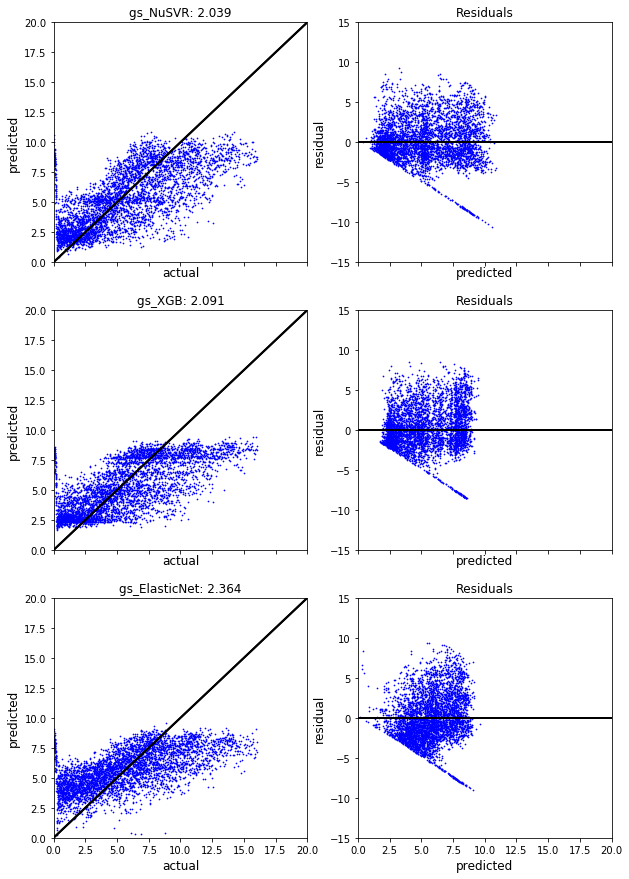

In [42]:
fig,axs = plt.subplots(3,2,figsize=(10,15), sharex=True)

for e,(mod,nm) in enumerate(zip([gs_NuSVR,gs_XGB,gs_EN],['gs_NuSVR','gs_XGB','gs_ElasticNet'])):
    plotResults(axs[e,0],mod,nm)
    plotResidual(axs[e,1],mod,nm)

# Predict on Test Data and Write Submission

In [43]:
submission = pd.read_csv(os.path.join(root,'sample_submission.csv'), index_col='seg_id')
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [51]:
X_test = list()
for seg_id in tqdm(submission.index[:]):
    seg = pd.read_csv(os.path.join(root,os.path.join('test',seg_id))+ '.csv')
    X_test.append(getFeatures(seg,seg_id,getY=False))

100%|██████████| 2624/2624 [01:49<00:00, 24.05it/s]


In [52]:
X_test = pd.concat(X_test).set_index(keys='segID',drop=True)

In [53]:
X_test['Kmeans_{}'.format(K)] = KM.predict(X_test).astype(float)

In [54]:
X_test['Kmeans_{}'.format(K2)] = KM2.predict(X_test.iloc[:,:-1]).astype(float)

In [55]:
X_test = X_test[[col for col in X]].copy()

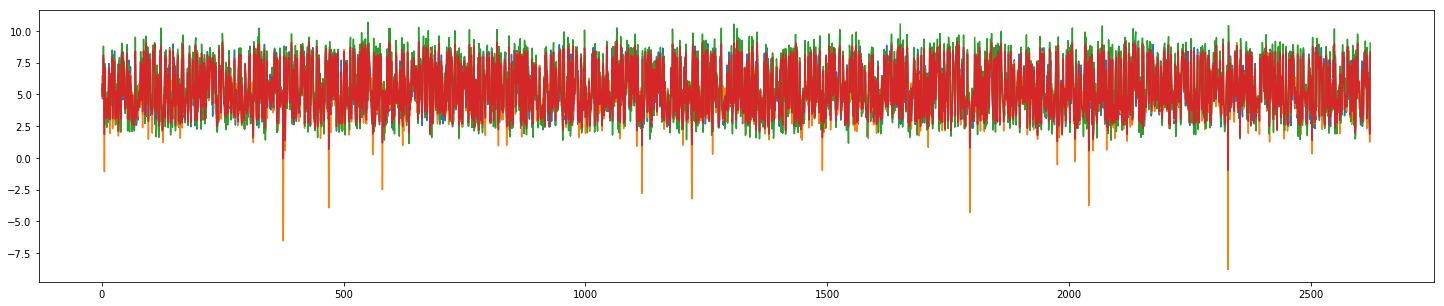

In [56]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
plt.plot(gs_XGB.predict(X_test))
plt.plot(gs_EN.predict(X_test))
plt.plot(gs_NuSVR.predict(X_test))
plt.plot((gs_XGB.predict(X_test)+gs_EN.predict(X_test)+gs_NuSVR.predict(X_test))/3.0);

In [59]:
submission['time_to_failure'] =  gs_XGB.predict(X_test) # gs_NuSVR.predict(X_test)
print(len(submission))
submission.head()

2624


,time_to_failure
seg_id,
seg_00030f,5.449429035186768
seg_0012b5,4.660824298858643
seg_00184e,5.066985607147217
seg_003339,7.856338024139404
seg_0042cc,5.268246650695801


In [60]:
submission.to_csv(os.path.join(root,'{}.2_XGB_submission.csv'.format(version)))

# 4.1 NuSVR is new best 1.522

## next trials
 - RFE with grid search
 - [catBoost](https://www.kaggle.com/jazivxt/aftershock?scriptVersionId=9634938)
 - [See this kernel](https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples)
